In [1]:
#import relevant Libraries 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
cleaned_data = pd.read_csv("Datasets/insurance_cleaned.csv")

In [3]:
data = cleaned_data.copy()
data = data.drop("Unnamed: 0", axis=1)

In [4]:
data.head()

,Year of Observation,Insurance Period,Residential,Building Painted,Building Fenced,Garden,Settlement,Building Dimension,Building Type,Date Of Occupancy,Number of Windows,Geo Code,Claim
0,2013-01-01,6 Months - 1 Year,0,Painted,Not Fenced,Has Garden,Urban area,290,1,1960,4,1053,0
1,2015-01-01,6 Months - 1 Year,0,Not Painted,Fenced,No Garden,Rural area,490,1,1850,4,1053,0
2,2014-01-01,6 Months - 1 Year,0,Painted,Not Fenced,Has Garden,Urban area,595,1,1960,4,1053,0
3,2013-01-01,6 Months - 1 Year,0,Not Painted,Not Fenced,Has Garden,Urban area,2840,1,1960,4,1053,0
4,2014-01-01,6 Months - 1 Year,0,Not Painted,Fenced,No Garden,Rural area,680,1,1800,3,1053,0


In [5]:
data["Geo Code"].nunique()

1307

Data Preprocessing 

In [6]:
# drop the geocode column it contains too many categories 
data1 = data.drop(["Geo Code"],axis=1)

In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7148 entries, 0 to 7147
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year of Observation  7148 non-null   object
 1   Insurance Period     7148 non-null   object
 2   Residential          7148 non-null   int64 
 3   Building Painted     7148 non-null   object
 4   Building Fenced      7148 non-null   object
 5   Garden               7148 non-null   object
 6   Settlement           7148 non-null   object
 7   Building Dimension   7148 non-null   int64 
 8   Building Type        7148 non-null   int64 
 9   Date Of Occupancy    7148 non-null   int64 
 10  Number of Windows    7148 non-null   int64 
 11  Claim                7148 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 670.2+ KB


In [8]:
data1['Year of Observation'] = data1['Year of Observation'].str[:4].str.strip()

data1['Year of Observation'] = data1['Year of Observation'].astype('int64')

In [9]:
data_with_dummies =  pd.get_dummies(data1, drop_first=True)

In [10]:
data_with_dummies.head()

,Year of Observation,Residential,Building Dimension,Building Type,Date Of Occupancy,Number of Windows,Claim,Insurance Period_6 Months - 1 Year,Building Painted_Painted,Building Fenced_Not Fenced,Garden_No Garden,Settlement_Urban area
0,2013,0,290,1,1960,4,0,1,1,1,0,1
1,2015,0,490,1,1850,4,0,1,0,0,1,0
2,2014,0,595,1,1960,4,0,1,1,1,0,1
3,2013,0,2840,1,1960,4,0,1,0,1,0,1
4,2014,0,680,1,1800,3,0,1,0,0,1,0


In [13]:
#lets  the import the module
from sklearn.preprocessing import StandardScaler

# Standardize inputs
scalar = StandardScaler()
#data_with_dummies['Number of windows(i)'] = scalar.fit_transform(np.adata_with_dummies['Number of Windows'].reshape(1, -1))
data_with_dummies['Log(Building Dimension)'] = np.log(data_with_dummies['Building Dimension'])
data_with_dummies[['Number of windows(i)', 'Building Dimension(i)']] = scalar.fit_transform(data_with_dummies[['Number of Windows','Log(Building Dimension)']])

data_with_dummies.drop(['Building Dimension','Number of Windows','Log(Building Dimension)'], axis=1,inplace=True)

<AxesSubplot:>

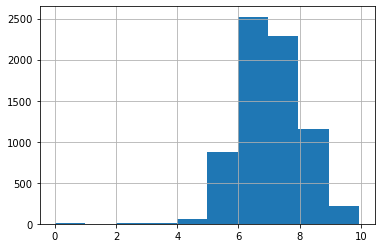

In [20]:
data_with_dummies['Log(Building Dimension)'].hist()

In [14]:
q = data_with_dummies['Building Dimension(i)'].quantile(0.01)
data_4 = data_with_dummies[data_with_dummies['Building Dimension(i)'] > q]

<AxesSubplot:>

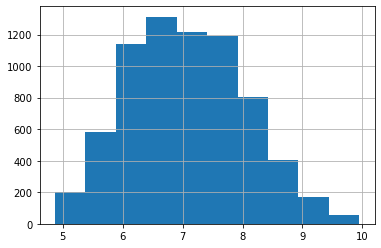

In [27]:
data_4['Log(Building Dimension)'].hist()

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_4[['Building Dimension(i)','Year of Observation','Number of windows(i)','Date Of Occupancy']]

vif = pd.DataFrame()
VIF = []
for i in range(variables.shape[1]):
    VIF.append(variance_inflation_factor(variables.values, i))
vif['VIF']= VIF
vif['Features'] = variables.columns
vif

,VIF,Features
0,1.295936,Building Dimension(i)
1,3531.769801,Year of Observation
2,1.198181,Number of windows(i)
3,3533.337534,Date Of Occupancy


Since Year and Date of Occupancy has the highest VIF, I will remove it from the model
This will drive the VIF of other variables down!!! 
So even if Number of Windows seems with a high VIF, too, once 'Year' is gone that will no longer be the case

In [17]:
data_5 = data_4.drop(['Date Of Occupancy','Year of Observation'], axis=1)

In [18]:
# lets define our targets and inputs variables 

y = data_5['Claim']
X = data_5.drop('Claim', axis=1)

In [19]:
X

,Residential,Building Type,Insurance Period_6 Months - 1 Year,Building Painted_Painted,Building Fenced_Not Fenced,Garden_No Garden,Settlement_Urban area,Number of windows(i),Building Dimension(i)
0,0,1,1,1,1,0,1,-0.128982,-1.311012
1,0,1,1,0,0,1,0,-0.128982,-0.804812
2,0,1,1,1,1,0,1,-0.128982,-0.617439
3,0,1,1,0,1,0,1,-0.128982,0.890953
4,0,1,1,0,0,1,0,-0.901145,-0.488573
...,...,...,...,...,...,...,...,...,...
7143,1,1,1,0,1,0,1,-0.128982,0.461001
7144,0,2,1,0,1,0,1,-0.128982,0.461001
7145,0,1,0,0,1,0,1,-0.128982,0.461001
7146,0,1,1,0,1,0,1,-0.128982,0.461001


In [20]:
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size=0.2, random_state=20)

In [21]:
x_train.corr()

,Residential,Building Type,Insurance Period_6 Months - 1 Year,Building Painted_Painted,Building Fenced_Not Fenced,Garden_No Garden,Settlement_Urban area,Number of windows(i),Building Dimension(i)
Residential,1.000000,0.333848,-0.016104,0.046048,-0.077379,0.077556,-0.077673,0.132994,0.072126
Building Type,0.333848,1.000000,-0.008549,0.051140,-0.022663,0.024064,-0.022523,0.190012,-0.006278
Insurance Period_6 Months - 1 Year,-0.016104,-0.008549,1.000000,0.040413,-0.033480,0.033041,-0.032450,0.004595,0.014221
Building Painted_Painted,0.046048,0.051140,0.040413,1.000000,0.575731,-0.574911,0.576142,-0.075321,-0.108779
Building Fenced_Not Fenced,-0.077379,-0.022663,-0.033480,0.575731,1.000000,-0.997880,0.999293,-0.132959,-0.143659
Garden_No Garden,0.077556,0.024064,0.033041,-0.574911,-0.997880,1.000000,-0.997881,0.134766,0.142586
Settlement_Urban area,-0.077673,-0.022523,-0.032450,0.576142,0.999293,-0.997881,1.000000,-0.134480,-0.143910
Number of windows(i),0.132994,0.190012,0.004595,-0.075321,-0.132959,0.134766,-0.134480,1.000000,0.378633
Building Dimension(i),0.072126,-0.006278,0.014221,-0.108779,-0.143659,0.142586,-0.143910,0.378633,1.000000


In [27]:
x_train_1 = x_train.drop('Settlement_Urban area', axis=1)

In [28]:
# Logistic Regression
#add constant

max_iter = 150  # Or any other value that you prefer
fit_kwargs = {'method': 'newton', 'maxiter': max_iter}


x_train_constant = sm.add_constant(x_train_1)
model = sm.Logit(y_train,x_train_constant)
results = model.fit(**fit_kwargs)
# Get the regression summary
results.summary()

Optimization terminated successfully.
         Current function value: 0.484817
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Claim   No. Observations:                 5660
Model:                          Logit   Df Residuals:                     5651
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 May 2023   Pseudo R-squ.:                  0.1060
Time:                        16:10:04   Log-Likelihood:                -2744.1
converged:                       True   LL-Null:                       -3069.4
Covariance Type:            nonrobust   LLR p-value:                3.079e-135
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -3.0349      0.976     -3.109      0.002      -4.948      -1.122
Residential                            0.0432      0.076      0.567      0.571      -0.106       0.192
Building Type                          0.2842      0.037      7.607      0.000       0.211       0.357
Insurance Period_6 Months - 1 Year     0.9362      0.148      6.341      0.000       0.647       1.226
Building Painted_Painted              -0.0549      0.098     -0.562      0.574      -0.247       0.137
Building Fenced_Not Fenced             0.2211      0.963      0.230      0.818      -1.666       2.108
Garden_No Garden                       0.0938      0.962      0.097      0.922      -1.792       1.980
Number of windows(i)                   0.1257      0.034      3.710      0.000       0.059       0.192
Building Dimension(i)                  0.7623      0.041     18.760      0.000       0.683       0.842
======================================================================================================
"""

# Accuracy


In [29]:
# This is a method to change the formatting of np arrays
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
# Should you want to go back to the default formatting, uncomment and execute the line below
#np.set_printoptions(formatter=None)
results.predict()

array([0.23, 0.19, 0.07, ..., 0.27, 0.42, 0.17])

In [30]:
np.array(y_train)

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [31]:
confusion_matrix = pd.DataFrame(results.pred_table())
confusion_matrix.columns = ['Predicted 0','Predicted 1']
confusions_matrix = confusion_matrix.rename(index={0: 'Actual 0',1:'Actual 1'})

confusions_matrix

,Predicted 0,Predicted 1
Actual 0,4201.0,143.0
Actual 1,1108.0,208.0


In [32]:
cm = np.array(confusion_matrix)
# Calculate the accuracy of the model
accuracy_train = (cm[0,0]+cm[1,1])/cm.sum()
accuracy_train

0.7789752650176679

In [35]:
def confusion_matrix2(data,actual_values,model):
        
        # Confusion matrix 
        
        # Parameters
        # ----------
        # data: data frame or array
            # data is a data frame formatted in the same way as your input data (without the actual values)
            # e.g. const, var1, var2, etc. Order is very important!
        # actual_values: data frame or array
            # These are the actual values from the test_data
            # In the case of a logistic regression, it should be a single column with 0s and 1s
            
        # model: a LogitResults object
            # this is the variable where you have the fitted model 
            # e.g. results_log in this course
        # ----------
        
        #Predict the values using the Logit model
        pred_values = model.predict(data)
        # Specify the bins 
        bins=np.array([0,0.5,1])
        # Create a histogram, where if values are between 0 and 0.5 tell will be considered 0
        # if they are between 0.5 and 1, they will be considered 1
        cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
        # Calculate the accuracy
        accuracy = (cm[0,0]+cm[1,1])/cm.sum()
        # Return the confusion matrix and 
        return cm, accuracy

In [43]:
confusion_matrix2(x_train_constant,y_train,results)

(array([[4202.00, 142.00],
        [1108.00, 208.00]]),
 0.7791519434628975)

# Testing 

In [33]:
x_test

,Residential,Building Type,Insurance Period_6 Months - 1 Year,Building Painted_Painted,Building Fenced_Not Fenced,Garden_No Garden,Settlement_Urban area,Number of windows(i),Building Dimension(i)
3779,0,2,1,0,1,0,1,-0.128982,0.075520
775,0,2,1,1,1,0,1,-0.128982,-0.207400
97,0,1,1,0,1,0,1,-0.128982,0.943847
3981,0,2,1,0,1,0,1,-0.128982,-1.344877
422,0,4,1,0,0,1,0,1.415344,0.274916
...,...,...,...,...,...,...,...,...,...
6842,1,3,1,0,0,1,0,-0.128982,0.366896
3086,0,2,1,0,0,1,0,-0.128982,-0.609363
3049,0,1,1,0,1,0,1,-0.128982,-0.693335
3490,0,2,1,0,0,1,0,-1.673307,-0.824711


In [36]:
#add constant
x_test_constant = sm.add_constant(x_test)


In [38]:
confusion_matrix2(x_test_constant,y_test,results)

ValueError: shapes (1416,10) and (9,) not aligned: 10 (dim 1) != 9 (dim 0)